# Graph MySQL data in Python

This notebook uses the MySQL world database, which can be downloaded here<br>http://dev.mysql.com/doc/index-other.html

Instructions for setting up the world database in MySQL are here<br>https://dev.mysql.com/doc/world-setup/en/

This notebook was created for this article in <em>Modern Data</em><br>http://mod.plot.ly/graph-data-from-mysql-database-in-python/ 

Questions, comments, suggestions?<br>Tweet to @plotlygraphs or ask Plotly's <a href="http://stackoverflow.com/questions/tagged/plotly">Stack Overflow channel</a>

In [74]:
import MySQLdb
import pandas as pd
import plotly.plotly as py
from plotly.graph_objs import *

In [75]:
conn = MySQLdb.connect(host="localhost", user="root", passwd="XXXX", db="world")
cursor = conn.cursor()

In [76]:
cursor.execute('select Name, Continent, Population, LifeExpectancy, GNP from Country');

In [77]:
rows = cursor.fetchall()

In [78]:
str(rows)[0:300]

"(('Aruba', 'North America', 103000L, 78.4, 828.0), ('Afghanistan', 'Asia', 22720000L, 45.9, 5976.0), ('Angola', 'Africa', 12878000L, 38.3, 6648.0), ('Anguilla', 'North America', 8000L, 76.1, 63.2), ('Albania', 'Europe', 3401200L, 71.6, 3205.0), ('Andorra', 'Europe', 78000L, 83.5, 1630.0), ('Netherla"

In [79]:
df = pd.DataFrame( [[ij for ij in i] for i in rows] )
df.rename(columns={0: 'Name', 1: 'Continent', 2: 'Population', 3: 'LifeExpectancy', 4:'GNP'}, inplace=True);
df = df.sort(['LifeExpectancy'], ascending=[1]);

In [80]:
df.head()

,Name,Continent,Population,LifeExpectancy,GNP
237,Zambia,Africa,9169000,37.2,3377
143,Mozambique,Africa,19680000,37.5,2891
148,Malawi,Africa,10925000,37.6,1687
238,Zimbabwe,Africa,11669000,37.8,5951
2,Angola,Africa,12878000,38.3,6648


Some country names cause serialization errors in early versions of Plotly's Python client. The code block below takes care of this.

In [81]:
country_names = df['Name']
for i in range(len(country_names)):
    try:
        country_names[i] = str(country_names[i]).decode('utf-8')
    except:
        country_names[i] = 'Country name decode error'

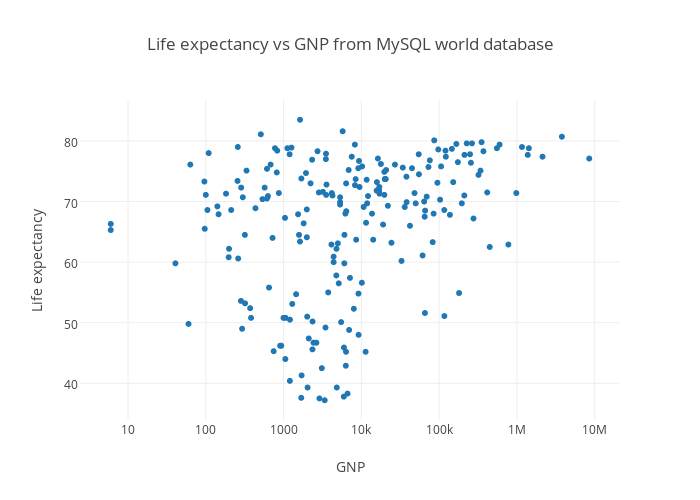

In [105]:
trace1 = Scatter(
    x=df['GNP'],
    y=df['LifeExpectancy'],
    text=country_names,
    mode='markers'
)
layout = Layout(
    title='Life expectancy vs GNP from MySQL world database',
    xaxis=XAxis( type='log', title='GNP' ),
    yaxis=YAxis( title='Life expectancy' ),
)
data = Data([trace1])
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='world GNP vs life expectancy')

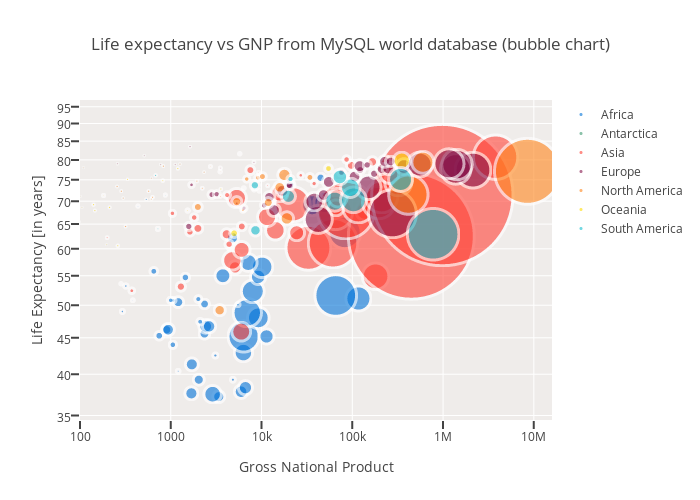

In [112]:
# (!) Set 'size' values to be proportional to rendered area,
#     instead of diameter. This makes the range of bubble sizes smaller
sizemode='area'       

# (!) Set a reference for 'size' values (i.e. a population-to-pixel scaling).
#     Here the max bubble area will be on the order of 100 pixels
sizeref=df['Population'].max()/1e2**2

colors = {
    'Asia':"rgb(255,65,54)", 
    'Europe':"rgb(133,20,75)",
    'Africa':"rgb(0,116,217)",
    'North America':"rgb(255,133,27)",
    'South America':"rgb(23,190,207)",
    'Antarctica':"rgb(61,153,112)",
    'Oceania':"rgb(255,220,0)",
}

# Define a hover-text generating function (returns a list of strings)
def make_text(X):
    return 'Country: %s\
    <br>Life Expectancy: %s years\
    <br>Population: %s million'\
    % (X['Name'], X['LifeExpectancy'], X['Population']/1e6)  

# Define a trace-generating function (returns a Scatter object)
def make_trace(X, continent, sizes, color):  
    return Scatter(
        x=X['GNP'],  # GDP on the x-xaxis
        y=X['LifeExpectancy'],    # life Exp on th y-axis
        name=continent,    # label continent names on hover
        mode='markers',    # (!) point markers only on this plot
        text=X.apply(make_text, axis=1).tolist(),
        marker= Marker(
            color=color,           # marker color
            size=sizes,            # (!) marker sizes (sizes is a list)
            sizeref=sizeref,       # link sizeref
            sizemode=sizemode,     # link sizemode
            opacity=0.6,           # (!) partly transparent markers
            line= Line(width=3,color="white")  # marker borders
        )
    )

# Initialize data object 
data = Data()

# Group data frame by continent sub-dataframe (named X), 
#   make one trace object per continent and append to data object
for continent, X in df.groupby('Continent'):
    
    sizes = X['Population']                 # get population array 
    color = colors[continent]               # get bubble color
    
    data.append(
        make_trace(X, continent, sizes, color)  # append trace to data object
    ) 

    # Set plot and axis titles
title = "Life expectancy vs GNP from MySQL world database (bubble chart)"
x_title = "Gross National Product"
y_title = "Life Expectancy [in years]"

# Define a dictionary of axis style options
axis_style = dict(  
    type='log',
    zeroline=False,       # remove thick zero line
    gridcolor='#FFFFFF',  # white grid lines
    ticks='outside',      # draw ticks outside axes 
    ticklen=8,            # tick length
    tickwidth=1.5         #   and width
)

# Make layout object
layout = Layout(
    title=title,             # set plot title
    plot_bgcolor='#EFECEA',  # set plot color to grey
    hovermode="closest",
    xaxis=XAxis(
        axis_style,      # add axis style dictionary
        title=x_title,   # x-axis title
        range=[2.0,7.2], # log of min and max x limits
    ),
    yaxis=YAxis(
        axis_style,      # add axis style dictionary
        title=y_title,   # y-axis title
    )
)

# Make Figure object
fig = Figure(data=data, layout=layout)

# (@) Send to Plotly and show in notebook
py.iplot(fig, filename='s3_life-gdp')

In [10]:
! pip install publisher --upgrade

import publisher
publisher.publish('mysql-ipython-notebook', '/python/graph-data-from-mysql-database-in-python', 
                  'Graph data from a MySQL database with Python', 
                  'How to graph data from a MySQL database with Python.',
                   uses_plotly_offline=True)

Requirement already up-to-date: publisher in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages
